In [1]:
from ift6758.ift6758.client.serving_client import ServingClient
from scripts.step3_clients.live_game_events import poll_and_predict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom

INFO:ift6758.ift6758.client.serving_client:Initializing client; base URL: http://127.0.0.1:5000


In [2]:
df_output, num = poll_and_predict(2025020335)
df_output

INFO:ift6758.ift6758.client.serving_client:Senting Data with ['distance_from_net', 'shot_angle', 'empty_net'] to app
INFO:ift6758.ift6758.client.serving_client:Predictions received


NEW EVENT TYPES: ['period-start', 'faceoff', 'hit', 'hit', 'shot-on-goal', 'shot-on-goal', 'giveaway', 'hit', 'shot-on-goal', 'missed-shot', 'blocked-shot', 'blocked-shot', 'stoppage', 'faceoff', 'missed-shot', 'shot-on-goal', 'stoppage', 'faceoff', 'blocked-shot', 'stoppage', 'faceoff', 'giveaway', 'shot-on-goal', 'hit', 'blocked-shot', 'stoppage', 'faceoff', 'shot-on-goal', 'missed-shot', 'shot-on-goal', 'shot-on-goal', 'stoppage', 'faceoff', 'giveaway', 'hit', 'missed-shot', 'hit', 'stoppage', 'faceoff', 'stoppage', 'faceoff', 'giveaway', 'stoppage', 'faceoff', 'missed-shot', 'giveaway', 'hit', 'missed-shot', 'missed-shot', 'blocked-shot', 'hit', 'giveaway', 'hit', 'shot-on-goal', 'shot-on-goal', 'blocked-shot', 'stoppage', 'faceoff', 'hit', 'shot-on-goal', 'shot-on-goal', 'shot-on-goal', 'stoppage', 'faceoff', 'hit', 'stoppage', 'faceoff', 'shot-on-goal', 'stoppage', 'faceoff', 'blocked-shot', 'delayed-penalty', 'missed-shot', 'penalty', 'faceoff', 'takeaway', 'shot-on-goal', 'shot

,event_type,x_coord,y_coord,event_team,home,away,period,time_remaining,goalie_name,situation_code,is_goal,distance_from_net,shot_angle,empty_net,empty_net_goalie,prediction,proba_non_goal,proba_goal
0,SHOT-ON-GOAL,-36,1,home,True,False,1,19:13,None,1551,0,53.009433,1.080924,0,1,0,0.997760,0.002240
1,SHOT-ON-GOAL,-78,-8,home,True,False,1,19:12,None,1551,0,13.601471,36.027373,0,1,0,0.968000,0.032000
2,SHOT-ON-GOAL,61,-35,away,False,True,1,18:43,None,1551,0,44.821870,51.340192,0,1,0,0.996089,0.003911
3,MISSED-SHOT,75,15,away,False,True,1,18:29,None,1551,0,20.518285,46.974934,0,1,0,0.979797,0.020203
4,BLOCKED-SHOT,-67,30,home,True,False,1,18:22,None,1551,0,37.202150,53.746162,0,1,0,0.993440,0.006560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,BLOCKED-SHOT,70,-12,away,False,True,3,00:48,None,1551,0,22.472205,32.275644,0,1,0,0.982275,0.017725
136,BLOCKED-SHOT,59,13,away,False,True,3,00:28,None,1551,0,32.695565,23.428693,0,1,0,0.991098,0.008902
137,SHOT-ON-GOAL,62,-4,home,True,False,4,04:40,None,1331,0,27.294688,8.426969,0,1,0,0.987182,0.012818
138,SHOT-ON-GOAL,-50,1,away,False,True,4,04:11,None,1331,0,39.012818,1.468801,0,1,0,0.994198,0.005802


In [5]:
def gaussian_smooth(hist, smoothing_factor=4, sigma=1.0):
    """
    Manual Gaussian smoothing on a finer grid.
    hist: (n_bins_x, n_bins_y)
    """
    n_bins_x, n_bins_y = hist.shape

    # --- 1. Fine grid dimensions ---
    fine_x = n_bins_x * smoothing_factor
    fine_y = n_bins_y * smoothing_factor

    # --- 2. Bin centers (normalized 0..1 space) ---
    bin_x_centers = np.linspace(0, 1, n_bins_x, endpoint=False) + 0.5/n_bins_x
    bin_y_centers = np.linspace(0, 1, n_bins_y, endpoint=False) + 0.5/n_bins_y
    bin_X, bin_Y = np.meshgrid(bin_x_centers, bin_y_centers, indexing="ij")
    bin_centers = np.column_stack((bin_X.ravel(), bin_Y.ravel()))
    bin_values = hist.ravel()

    # --- 3. Fine grid cell centers ---
    cell_x_centers = np.linspace(0, 1, fine_x, endpoint=False) + 0.5/fine_x
    cell_y_centers = np.linspace(0, 1, fine_y, endpoint=False) + 0.5/fine_y
    cell_X, cell_Y = np.meshgrid(cell_x_centers, cell_y_centers, indexing="ij")
    cell_centers = np.column_stack((cell_X.ravel(), cell_Y.ravel()))

    # --- 4. Gaussian kernel weights ---
    diff = cell_centers[:, None, :] - bin_centers[None, :, :]
    squared_distances = np.sum(diff**2, axis=2)
    weights = np.exp(-squared_distances / (2 * sigma * sigma))

    # weighted sum from all bins
    fine_values = weights @ bin_values
    fine_grid = fine_values.reshape(fine_x, fine_y)
    return fine_grid
    
def home_map(df, n_bins=50, smoothing_factor=4, variance=1.0,
             out_width=400, out_height=170):
    # --- 1. Keep only shot-like events from home team ---
    df = df[df["home"] == True].copy()

    # --- 2. Flip coordinates automatically for odd periods ---
    odd_mask = (df["period"] % 2 == 1)
    df.loc[odd_mask, "x_coord"] *= -1
    df.loc[odd_mask, "y_coord"] *= -1

    # --- 3. Bin ranges ---
    x_min, x_max = 0, 100
    y_min, y_max = -42.5, 42.5

    x_bins = np.linspace(x_min, x_max, n_bins + 1)
    y_bins = np.linspace(y_min, y_max, n_bins + 1)

    # --- 4. Histogram (xG-weighted) ---
    hist, _, _ = np.histogram2d(
        df["x_coord"],
        df["y_coord"],
        bins=[x_bins, y_bins],
        weights=df["proba_goal"]   # <── xG weighting
    )

    # --- 5. Manual Gaussian smoothing ---
    smooth_hist = gaussian_smooth(hist, smoothing_factor, sigma=variance)

    # --- 6. Interpolation to final size (width × height) ---
    current_h, current_w = smooth_hist.shape
    zoom_x = out_width  / current_w
    zoom_y = out_height / current_h
    final_img = zoom(smooth_hist, (zoom_y, zoom_x))

    # --- 7. Display ---
    plt.figure(figsize=(8, 4))
    plt.imshow(
        final_img.T,
        origin="lower",
        extent=[x_min, x_max, y_min, y_max],
        cmap="hot",
        aspect="auto"
    )
    plt.colorbar(label="xG Density")
    plt.title("Home Team xG Heatmap")
    plt.xlabel("X (ft)")
    plt.ylabel("Y (ft)")
    plt.show()

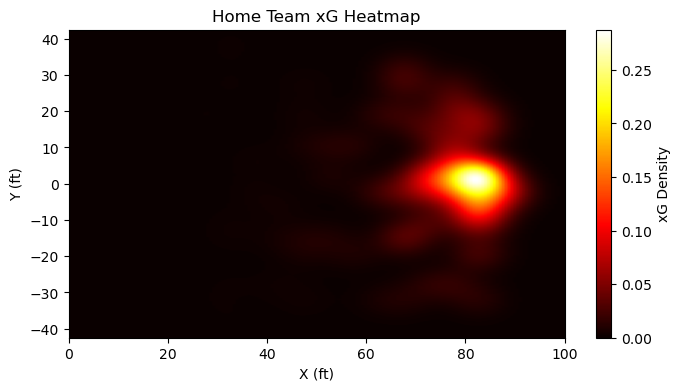

In [6]:
home_map(df_output, 20, 10, 0.04)

In [10]:
def away_map(df, n_bins=50, smoothing_factor=4, variance=1.0,
             out_width=400, out_height=170):
    # --- 1. Keep only shot-like events from away team ---
    df = df[df["away"] == True].copy()

    # --- 2. Flip coordinates automatically for odd periods (same rule as home) ---
    # NHL play direction flips every period for BOTH teams.
    odd_mask = (df["period"] % 2 == 0)
    df.loc[odd_mask, "x_coord"] *= -1
    df.loc[odd_mask, "y_coord"] *= -1

    # --- 3. Bin ranges ---
    x_min, x_max = 0, 100
    y_min, y_max = -42.5, 42.5

    x_bins = np.linspace(x_min, x_max, n_bins + 1)
    y_bins = np.linspace(y_min, y_max, n_bins + 1)

    # --- 4. Histogram (xG-weighted) ---
    hist, _, _ = np.histogram2d(
        df["x_coord"],
        df["y_coord"],
        bins=[x_bins, y_bins],
        weights=df["proba_goal"]     # still xG weighting
    )

    # --- 5. Manual Gaussian smoothing ---
    smooth_hist = gaussian_smooth(hist, smoothing_factor, sigma=variance)

    # --- 6. Interpolation to final size (width × height) ---
    current_h, current_w = smooth_hist.shape
    zoom_x = out_width  / current_w
    zoom_y = out_height / current_h
    final_img = zoom(smooth_hist, (zoom_y, zoom_x))

    # --- 7. Display ---
    plt.figure(figsize=(8, 4))
    plt.imshow(
        final_img.T,
        origin="lower",
        extent=[x_min, x_max, y_min, y_max],
        cmap="hot",
        aspect="auto"
    )
    plt.colorbar(label="xG Density")
    plt.title("Away Team xG Heatmap")
    plt.xlabel("X (ft)")
    plt.ylabel("Y (ft)")
    plt.show()


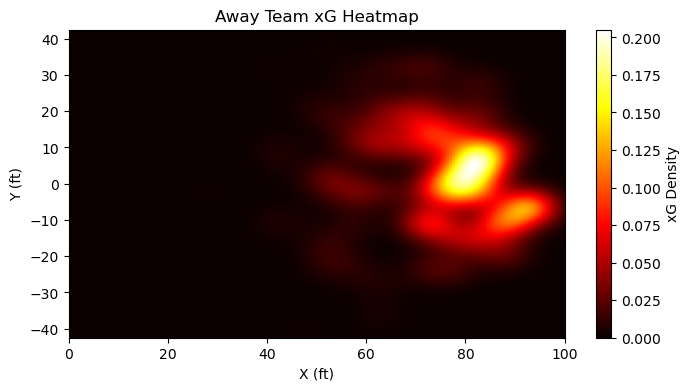

In [11]:
away_map(df_output, 20, 10, 0.04)

In [12]:
def compute_heatmaps(df, 
                     n_bins=50, 
                     smoothing_factor=4, 
                     variance=1.0,
                     out_width=400, 
                     out_height=170):
    """
    Returns:
        home_img : np.array  (out_height × out_width)
        away_img : np.array  (out_height × out_width)
    """

    def make_team_map(df_team, flip_mask):
        # Flip coordinates based on mask
        df_team = df_team.copy()
        df_team.loc[flip_mask, "x_coord"] *= -1
        df_team.loc[flip_mask, "y_coord"] *= -1

        # Bin ranges
        x_min, x_max = 0, 100
        y_min, y_max = -42.5, 42.5
        x_bins = np.linspace(x_min, x_max, n_bins + 1)
        y_bins = np.linspace(y_min, y_max, n_bins + 1)

        # xG-weighted histogram
        hist, _, _ = np.histogram2d(
            df_team["x_coord"],
            df_team["y_coord"],
            bins=[x_bins, y_bins],
            weights=df_team["proba_goal"]
        )

        # Smoothing
        smooth_hist = gaussian_smooth(hist, smoothing_factor, sigma=variance)

        # Interpolate to final size
        current_h, current_w = smooth_hist.shape
        zoom_x = out_width  / current_w
        zoom_y = out_height / current_h
        final_img = zoom(smooth_hist, (zoom_y, zoom_x))

        return final_img

    # Filter valid shot events
    df = df[df["event_type"].isin(["SHOT-ON-GOAL", "MISSED-SHOT", "BLOCKED-SHOT"])].copy()

    # HOME TEAM
    df_home = df[df["home"] == True]
    home_flip_mask = (df_home["period"] % 2 == 1)   # flip on odd periods
    home_img = make_team_map(df_home, home_flip_mask)

    # AWAY TEAM
    df_away = df[df["away"] == True]
    away_flip_mask = (df_away["period"] % 2 == 0)   # flip on even periods
    away_img = make_team_map(df_away, away_flip_mask)

    return home_img, away_img

In [13]:
def display_heatmaps(home_img, away_img,
                     x_min=0, x_max=100,
                     y_min=-42.5, y_max=42.5):
    """
    Displays the home and away heatmaps side by side.
    """

    plt.figure(figsize=(12, 5))

    # --- Home ---
    plt.subplot(1, 2, 1)
    plt.imshow(
        home_img.T,
        origin="lower",
        extent=[x_min, x_max, y_min, y_max],
        cmap="hot",
        aspect="auto"
    )
    plt.colorbar(label="xG Density")
    plt.title("Home Team xG Heatmap")
    plt.xlabel("X (ft)")
    plt.ylabel("Y (ft)")

    # --- Away ---
    plt.subplot(1, 2, 2)
    plt.imshow(
        away_img.T,
        origin="lower",
        extent=[x_min, x_max, y_min, y_max],
        cmap="hot",
        aspect="auto"
    )
    plt.colorbar(label="xG Density")
    plt.title("Away Team xG Heatmap")
    plt.xlabel("X (ft)")
    plt.ylabel("Y (ft)")

    plt.tight_layout()
    plt.show()

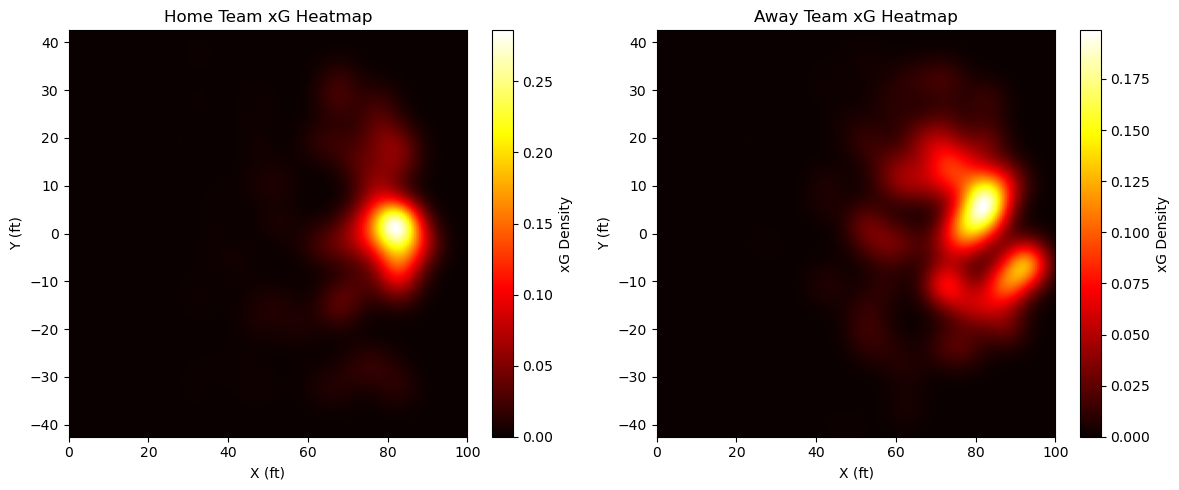

In [15]:
home_img, away_img = compute_heatmaps(df_output, 20, 10, 0.04)
display_heatmaps(home_img, away_img)

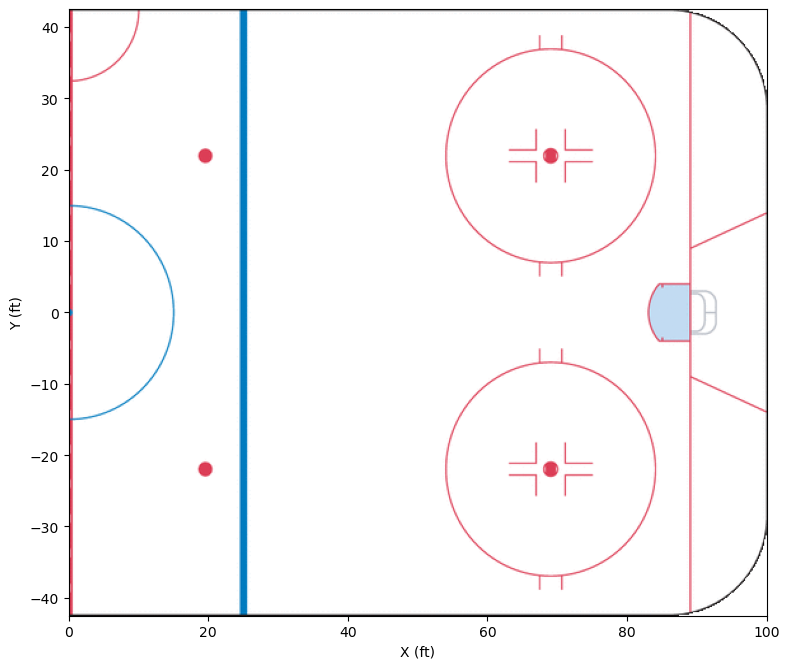

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_rink_image(path="figures/nhl_rink.png",
                       x_min=0, x_max=100,
                       y_min=-42.5, y_max=42.5):

    img = mpimg.imread(path)

    # --- Use only the right half of the image ---
    h, w, c = img.shape
    img = img[:, w//2:, :]   # <-- RIGHT SIDE

    rink_width  = x_max - x_min          # 100
    rink_height = y_max - y_min          # 85
    aspect = rink_width / rink_height    # ≈ 1.176

    plt.figure(figsize=(8, 8 / aspect))

    plt.imshow(
        img,
        origin="lower",
        extent=[x_min, x_max, y_min, y_max],
        aspect="auto"
    )

    plt.xlabel("X (ft)")
    plt.ylabel("Y (ft)")
    plt.tight_layout()
    plt.show()
display_rink_image()

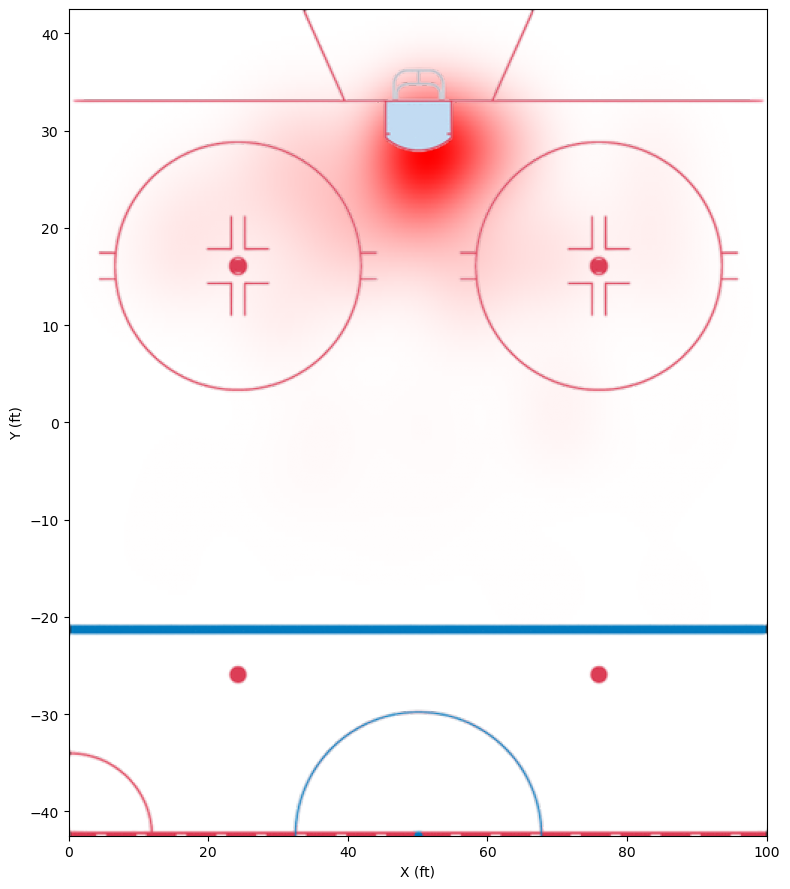

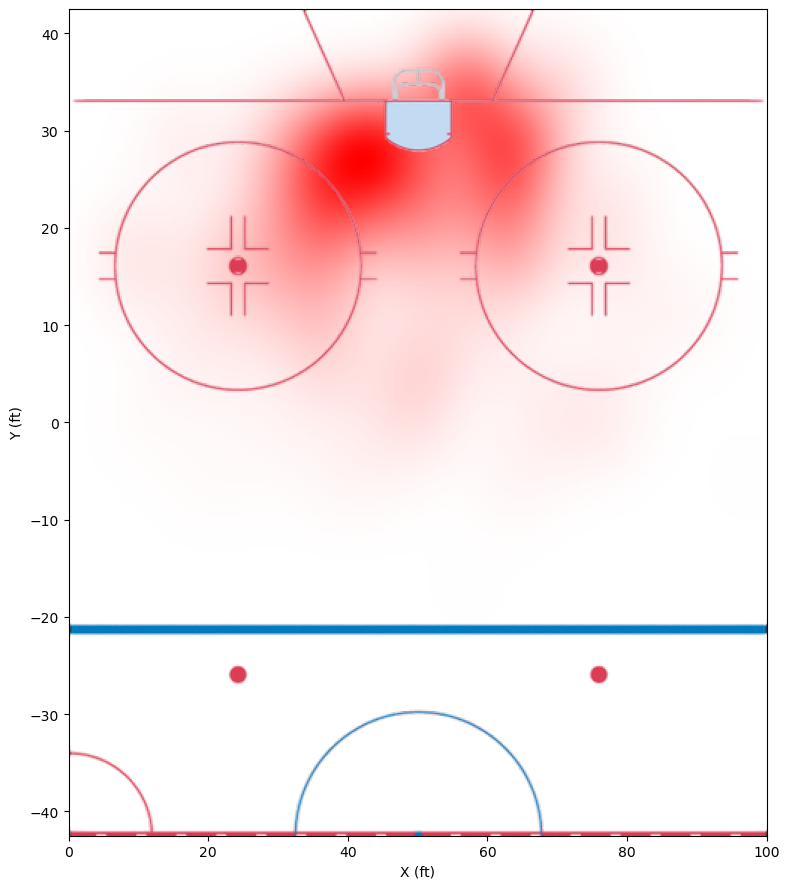

In [105]:
from matplotlib.colors import LinearSegmentedColormap
white_to_red = LinearSegmentedColormap.from_list(
    "white_to_red",
    [(1,1,1), (0,1,0)]   # white → red
)

def overlay_rink_on_heatmap(heatmap,
                            path="figures/nhl_rink-no_background.png",
                            x_min=0, x_max=100,
                            y_min=-42.5, y_max=42.5,
                            alpha_heatmap=1):

    img = mpimg.imread(path)
    h, w, c = img.shape
    img = img[:, w//2:, :]   # right half

    # Create white → red colormap
    white_to_red = LinearSegmentedColormap.from_list(
        "white_to_red", [(1,1,1), (1,0,0)]
    )

    rink_width  = x_max - x_min
    rink_height = y_max - y_min
    aspect = rink_width / rink_height

    plt.figure(figsize=(8, 9))

    # --- Draw heatmap ---
    plt.imshow(
        np.rot90(heatmap.T, k=-1),
        origin="lower",
        extent=[x_min, x_max, y_min, y_max],
        cmap=white_to_red,
        alpha=alpha_heatmap,
        aspect="auto"
    )

    # --- Draw transparent rink on top ---
    plt.imshow(
        np.rot90(img, k=-1),
        origin="lower",
        extent=[x_min, x_max, y_min, y_max],
        aspect="auto",
    )

    plt.xlabel("X (ft)")
    plt.ylabel("Y (ft)")
    plt.tight_layout()
    plt.show()
home_img, away_img = compute_heatmaps(df_output, 15, 10, 0.05)
overlay_rink_on_heatmap(home_img)
overlay_rink_on_heatmap(away_img)